In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

Base = automap_base()

In [4]:
database_path = os.path.join("Resources", "hawaii.sqlite")
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()
Base.metadata.create_all(conn)

In [5]:
#Code if you like to create pandas df directly from the DB
#measurement_data = pd.read_sql('select * from measurement', conn)
#measurement_data.head()

#station_data = pd.read_sql('select * from station', conn)
#station_data.head(20)


In [6]:
#Inspect the sqlite database
inspector = inspect (engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
# reflect the tables
Base.prepare(engine, reflect =True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
#Get a preview of the data from the Measurement table
first_row = session.query(Measurement).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fdc0a3594c0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(f"The most recent measurement taken is:{recent_date.date}")

The most recent measurement taken is:2017-08-23


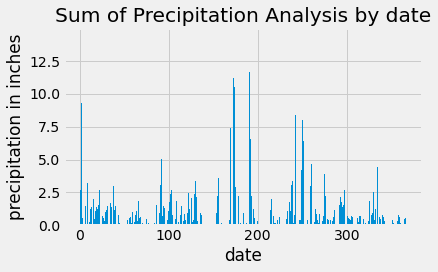

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_separated = recent_date.date.split('-')

# Calculate the date one year from the last date in data set.
year_back = int(date_separated[0])-1
search_date = f"{year_back}-{date_separated[1]}-{date_separated[2]}"

# Perform a query to retrieve the data and precipitation scores
prcp_base = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= search_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_analysis = pd.DataFrame(prcp_base)
prcp_analysis.head()

# Sort the dataframe by date
prcp_analysis.sort_values(by='date', inplace=True)
prcp_grouped = prcp_analysis.groupby(['date']).sum()
prcp_grouped['date']= prcp_grouped.index
prcp_grouped.head()
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
xpos = np.arange(len(prcp_grouped['date']))+1
ax.bar(xpos,prcp_grouped['prcp'])
ax.set_xlabel("date")
ax.set_ylabel("precipitation in inches")
#ax.set_xticklabels(prcp_grouped['date'])
ax.set_title("Sum of Precipitation Analysis by date")
fig.tight_layout()
plt.show()



In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_analysis.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
#Get a preview of the data from the Measurement table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fdc0b1663d0>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [16]:
# Design a query to calculate the total number stations in the dataset
st_number = session.query(Station).count()
print(f"The are {st_number} sations")

The are 9 sations


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = pd.DataFrame(session.query(Measurement.station).all()).value_counts()
active_stations

station    
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
dtype: int64

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#The most active station is stored in the index 0 position

st_stats = session.query(func.avg(Measurement.tobs),func.min(Measurement.tobs), func.max(Measurement.tobs))\
.filter(Measurement.station == active_stations.index[0][0]).all()
print(f"The average temp is {st_stats[0][0]}, the maximum temperature is {st_stats[0][2]} and the minimum temperature is {st_stats[0][1]}\
 for the {active_stations.index[0][0]} station")

The average temp is 71.66378066378067, the maximum temperature is 85.0 and the minimum temperature is 54.0 for the USC00519281 station


<function matplotlib.pyplot.show(close=None, block=None)>

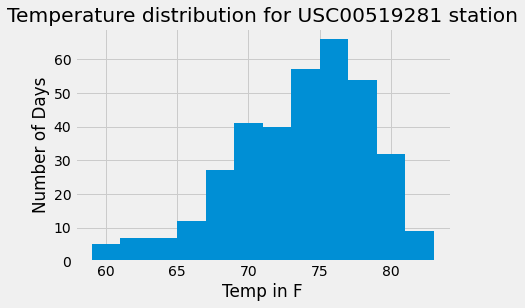

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(Measurement).filter(Measurement.station == active_stations.index[0][0])\
.order_by(Measurement.date.desc()).first()

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_separated = last_date.date.split('-')

# Calculate the date one year from the last date in data set.
year_back = int(date_separated[0])-1
search_date = f"{year_back}-{date_separated[1]}-{date_separated[2]}"

# Perform a query to retrieve the data and precipitation scores
station_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= search_date,Measurement.station == active_stations.index[0][0]).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
st_analysis = pd.DataFrame(station_data)
st_analysis.head()

plt.hist(st_analysis['tobs'],bins=12)
plt.title(f"Temperature distribution for {active_stations.index[0][0]} station" )
plt.ylabel('Number of Days')
plt.xlabel('Temp in F')
plt.show





# Close session

In [20]:
# Close Session
session.close()